# Physical Risk Propagation Model — EU-27 SAM (Scenario Runs)

This notebook is the *single entry point* to:
- load the latest EU-27 SAM (long format) from Databricks
- extract IO-style blocks (`Z`, `FD`, `X`, `A`, `globsec_of`, `node_labels`)
- run the **physical-risk propagation** model under supply/demand shocks
- inspect and visualize impacts (country / sector), including a Europe choropleth


## 0) Environment and imports

**Prerequisites**
- You are running on a Databricks cluster or a local environment with a working Spark session (`spark`) connected to the Databricks metastore.
- The project `src/` folder is importable (we add it to `sys.path` below).

If you are running locally, ensure Databricks Connect is configured and `spark` is available.


In [1]:
import os
import sys

import numpy as np
import pandas as pd

# --- Make project imports work from the repo root
PROJECT_ROOT = os.path.abspath(os.getcwd())
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from data_io.eurostat_sam import load_sam_latest_year, extract_model_inputs_from_sam
from src.data_io.sector_decoder import build_sector_decoder
from io_climate.model import IOClimateModel


## 1) Load SAM and extract model inputs

The SAM is expected in **long format** and must include:
- `geo_ava`, `ind_ava` (producer country/account)
- `geo_use`, `ind_use` (user country/account)
- `value` (flow)
- `share` (precomputed coefficient: cell value / total output of user column)

`extract_model_inputs_from_sam(...)` builds:
- `Z` (n×n) intermediate flows among production sectors (`P_*`)
- `FD` (n,) final demand from accounts `[HH, GOV, CF, WRL_REST]`
- `X` (n,) gross output = `row_sum(Z) + FD`
- `A` (n×n) technical coefficients (from `share` for the `P_* → P_*` block)
- `globsec_of` (n,) maps each node to its global sector id (same `P_*` across countries)
- `node_labels` list of `"CC::P_..."` strings, consistent with matrix ordering


In [2]:
# Load latest year from Databricks table
sam_df, latest_year = load_sam_latest_year(spark)
print("SAM year:", latest_year)
print("Rows:", sam_df.count())

# Extract model inputs (numpy arrays + labels)
Z, FD, X, A, globsec_of, node_labels = extract_model_inputs_from_sam(sam_df)

n = len(node_labels)
print("n nodes:", n)
print("Z shape:", Z.shape, "A shape:", A.shape, "FD shape:", FD.shape, "X shape:", X.shape)


SAM year: 2022
Rows: 2040159
n nodes: 1695
Z shape: (1695, 1695) A shape: (1695, 1695) FD shape: (1695,) X shape: (1695,)


## 1b) Sector name mapping table

If available, you can load a sector mapping/decoder table to attach human-readable sector names to results. 
At this stage, the model uses **NACE codes** from `node_labels` (e.g. `IT::P_D35`). The mapping is **not** required to run the model.


In [3]:
sectors_in_sam = sorted({lbl.split("::")[1] for lbl in node_labels})
sector_decoder = build_sector_decoder(
    spark,
    sectors_in_sam=sectors_in_sam,
)
print("Sectors in SAM:", len(sectors_in_sam))
display(sector_decoder)

Sectors in SAM: 63


{'P_C10-12': 'Manufacture of food products; beverages and tobacco products',
 'P_K65': 'Insurance, reinsurance and pension funding, except compulsory social security',
 'P_D35': 'Electricity, gas, steam and air conditioning supply',
 'P_R90-92': 'Creative, arts and entertainment activities; libraries, archives, museums and other cultural activities; gambling and betting activities',
 'P_J58': 'Publishing activities',
 'P_M69_70': 'Legal and accounting activities; activities of head offices; management consultancy activities',
 'P_C29': 'Manufacture of motor vehicles, trailers and semi-trailers',
 'P_M71': 'Architectural and engineering activities; technical testing and analysis',
 'P_O84': 'Public administration and defence; compulsory social security',
 'P_C19': 'Manufacture of coke and refined petroleum products',
 'P_S94': 'Activities of membership organisations',
 'P_J62_63': 'Computer programming, consultancy, and information service activities',
 'P_A03': 'Fishing and aquaculture

### 1.1 Quick sanity checks

These checks catch the most common ingestion issues (ordering mismatches, missing blocks, negative values).


In [4]:
assert Z.shape == (n, n)
assert A.shape == (n, n)
assert FD.shape == (n,)
assert X.shape == (n,)
assert len(globsec_of) == n

print("Min values — Z:", float(Z.min()), "A:", float(A.min()), "FD:", float(FD.min()), "X:", float(X.min()))
print("Totals — sum(Z):", float(Z.sum()), "sum(FD):", float(FD.sum()), "sum(X):", float(X.sum()))

# Accounting identity at baseline (row accounting)
row_gap = np.linalg.norm(X - (FD + Z.sum(axis=1)), ord=1)
print("Baseline accounting gap (L1):", float(row_gap))




Min values — Z: 0.0 A: 0.0 FD: -0.040412221578703625 X: 1.2000000000907844
Totals — sum(Z): 13941501.474966172 sum(FD): 14831340.773248244 sum(X): 28772842.248214405
Baseline accounting gap (L1): 0.0


## 2) Instantiate the model

`IOClimateModel` stores the **baseline economy** internally (`Z0`, `A0`, `L0`, `X0`, `FD0`), and enforces a fixed **global-technology** matrix `A_G` derived from baseline global-sector aggregation.

For scenario diagnostics, keep a copy of baseline output **outside** the model, to avoid any ambiguity.


In [5]:
model = IOClimateModel(
    Z=Z,
    FD=FD,
    X=X,
    globsec_of=globsec_of,
    A=A,
    node_labels=node_labels,
)

# Baseline copies for diagnostics
X_baseline = X.copy()
FD_baseline = FD.copy()

print("Model ready.")
print("Baseline total output:", float(X_baseline.sum()))
print("Baseline total final demand:", float(FD_baseline.sum()))
print("Global sectors:", model.S_glob)


Model ready.
Baseline total output: 28772842.248214405
Baseline total final demand: 14831340.773248244
Global sectors: 63


## 3) Define and run a scenario

You can define shocks either:
- by providing `sd` and `sp` vectors directly, or
- by specifying `(country_codes, sector_codes, supply_shock_pct, demand_shock_pct)`.

This notebook uses **scenario mode** for convenience.

Notes:
- Supply shock reduces capacity: `X_cap = X0 * (1 - sp)`
- Demand shock reduces initial final demand: `FD_post = FD0 * (1 - sd)`
- Outer iteration reduces demand *further* only where implied demand is lower than `FD_post` (elementwise monotone update).


In [6]:
scenario = dict(
    # Supply shock target: France energy/utilities
    supply_country_codes=["FR"],
    supply_sector_codes=["P_D35"],        # Electricity, gas, steam
    supply_shock_pct=5.0,

    # Demand shock target: all countries, several service sectors
    demand_country_codes=None,            # all countries
    demand_sector_codes=["P_H49", "P_J61", "P_M69_70"],  # transport, telecom, professional services
    demand_shock_pct=2.5,

    gamma=0.5,
    max_iter=200,
    tol=1e-4,
    return_history=False,
)

results = model.run(**scenario)

print("Converged:", results["converged"])
print("Iterations:", results["iterations"])


Converged: True
Iterations: 9


## 4) Build node-level impact table

We compute output losses at node level and aggregate by:
- country
- sector


In [7]:
X_final = results["X_supply_final"]

df_nodes = pd.DataFrame({
    "node": node_labels,
    "country": [lbl.split("::")[0] for lbl in node_labels],
    "sector":  [lbl.split("::")[1] for lbl in node_labels],
    "X_baseline": X_baseline,
    "X_final": X_final,
})

df_nodes["loss_abs"] = df_nodes["X_baseline"] - df_nodes["X_final"]
df_nodes["loss_pct"] = np.where(
    df_nodes["X_baseline"] > 0,
    100.0 * df_nodes["loss_abs"] / df_nodes["X_baseline"],
    0.0
)
df_nodes["sector_name"] = (
    df_nodes["sector"]
    .map(sector_decoder)
    .fillna(df_nodes["sector"])
)


df_nodes.sort_values("loss_abs", ascending=False).head(10)
df_nodes


,node,country,sector,X_baseline,X_final,loss_abs,loss_pct,sector_name
0,AT::P_A01,AT,P_A01,10170.862001,9328.854232,842.007769,8.278627,"Crop and animal production, hunting and relate..."
1,AT::P_A02,AT,P_A02,2903.627000,2559.928483,343.698517,11.836869,Forestry and logging
2,AT::P_A03,AT,P_A03,111.881000,104.604929,7.276071,6.503402,Fishing and aquaculture
3,AT::P_B,AT,P_B,3452.811000,3232.572060,220.238940,6.378540,P_B
4,AT::P_C10-12,AT,P_C10-12,28074.827001,26417.892924,1656.934078,5.901850,Manufacture of food products; beverages and to...
...,...,...,...,...,...,...,...,...
1690,SK::P_R93,SK,P_R93,438.938000,423.064669,15.873331,3.616304,Sports activities and amusement and recreation...
1691,SK::P_S94,SK,P_S94,361.633000,347.735163,13.897837,3.843078,Activities of membership organisations
1692,SK::P_S95,SK,P_S95,105.702000,99.456229,6.245771,5.908849,Repair of computers and personal and household...
1693,SK::P_S96,SK,P_S96,732.239000,699.748021,32.490979,4.437210,Other personal service activities


### 4.1 Aggregate losses by country and sector (absolute)

`loss_abs` is in the same unit as the SAM flows (typically EUR).


In [8]:
df_country = (
    df_nodes.groupby("country", as_index=False)
    .agg(X_baseline=("X_baseline","sum"), X_final=("X_final","sum"), loss_abs=("loss_abs","sum"))
)
df_country["loss_pct"] = np.where(df_country["X_baseline"]>0, 100.0*df_country["loss_abs"]/df_country["X_baseline"], 0.0)
df_country = df_country.sort_values("loss_abs", ascending=False)

df_sector = (
    df_nodes
    .groupby(["sector", "sector_name"], as_index=False)
    .agg(
        X_baseline=("X_baseline", "sum"),
        X_final=("X_final", "sum"),
        loss_abs=("loss_abs", "sum"),
    )
)


df_sector["loss_pct"] = np.where(df_sector["X_baseline"]>0, 100.0*df_sector["loss_abs"]/df_sector["X_baseline"], 0.0)
df_sector = df_sector.sort_values("loss_abs", ascending=False)

display(df_country.head(10))
display(df_sector.head(10))


,country,X_baseline,X_final,loss_abs,loss_pct
5,DE,6.905942e+06,6.641054e+06,264888.488765,3.835660
11,FR,4.681131e+06,4.436362e+06,244768.766663,5.228838
15,IT,3.751974e+06,3.601268e+06,150706.381260,4.016722
9,ES,2.442810e+06,2.346871e+06,95938.948109,3.927401
20,NL,1.738425e+06,1.666283e+06,72141.647299,4.149829
21,PL,1.310212e+06,1.256983e+06,53228.869743,4.062615
0,AT,8.110387e+05,7.635918e+05,47446.858171,5.850135
1,BE,1.099704e+06,1.056219e+06,43485.006798,3.954246
24,SE,9.215626e+05,8.844278e+05,37134.772890,4.029544
22,PT,4.367816e+05,4.113631e+05,25418.463747,5.819491


,sector,sector_name,X_baseline,X_final,loss_abs,loss_pct
26,P_F,Construction,2.166042e+06,2.077740e+06,88302.161073,4.076660
43,P_L,Real estate activities,1.951634e+06,1.871394e+06,80240.132199,4.111433
23,P_D35,"Electricity, gas, steam and air conditioning s...",1.140940e+06,1.075913e+06,65027.111573,5.699433
28,P_G46,"Wholesale trade, except of motor vehicles and ...",1.541742e+06,1.478092e+06,63649.859990,4.128437
4,P_C10-12,Manufacture of food products; beverages and to...,1.127953e+06,1.078799e+06,49154.609170,4.357858
44,P_M69_70,Legal and accounting activities; activities of...,9.442642e+05,8.959074e+05,48356.742345,5.121103
53,P_O84,Public administration and defence; compulsory ...,1.367827e+06,1.320892e+06,46934.228803,3.431299
55,P_Q86,Human health activities,1.168269e+06,1.128220e+06,40048.970354,3.428061
29,P_G47,"Retail trade, except of motor vehicles and mot...",1.047942e+06,1.008823e+06,39119.489377,3.732982
40,P_K64,"Financial service activities, except insurance...",7.225892e+05,6.859463e+05,36642.881752,5.071053


## 5) Visualizations

This section provides:
- choropleth map (Europe) of absolute or percent losses by country
- bar charts of absolute losses by country and sector

If `matplotlib` is not installed in your environment, the bar charts will fall back to tables.


In [9]:
# --- ISO2 -> ISO3 conversion for Plotly (Plotly choropleth requires ISO-3)
try:
    import pycountry

    def iso2_to_iso3(iso2: str):
        c = pycountry.countries.get(alpha_2=iso2)
        return c.alpha_3 if c else None

    df_country["iso3"] = df_country["country"].apply(iso2_to_iso3)

    unmapped = df_country[df_country["iso3"].isna()]
    if len(unmapped) > 0:
        print("Warning: unmapped ISO-2 codes:", unmapped["country"].tolist())

except ModuleNotFoundError:
    df_country["iso3"] = None
    print("pycountry not installed; choropleth map will not work until you install it: pip install pycountry")


In [10]:
# --- Choropleth (Europe scope), absolute losses
import plotly.express as px

df_map = df_country.dropna(subset=["iso3"]).copy()

fig = px.choropleth(
    df_map,
    locations="iso3",
    locationmode="ISO-3",
    color="loss_abs",
    hover_name="country",
    hover_data={"loss_abs": True, "loss_pct": True, "iso3": False, "country": False},
    color_continuous_scale="Reds",
    title="Total Output Loss by Country (absolute)",
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()


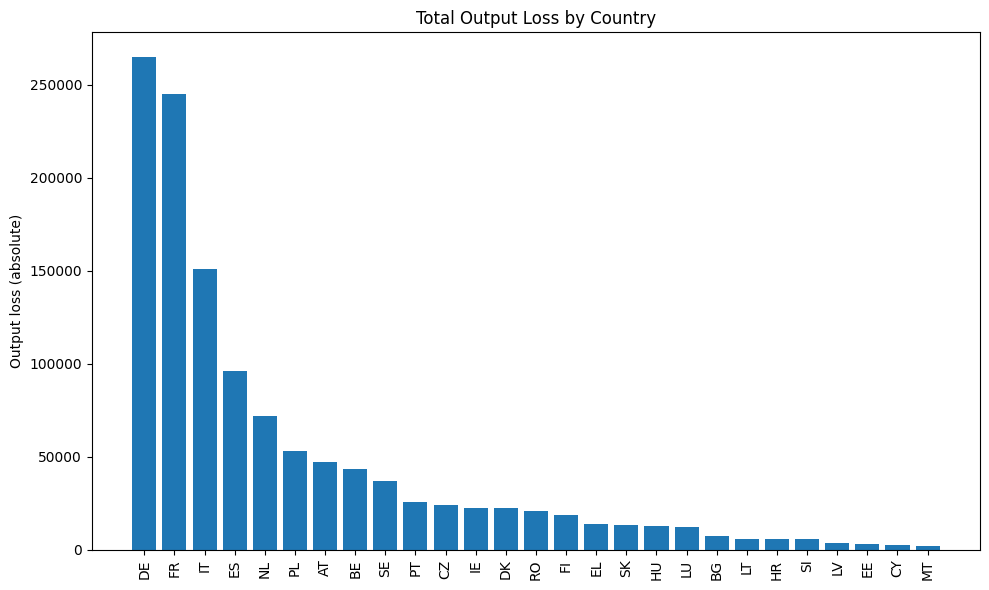

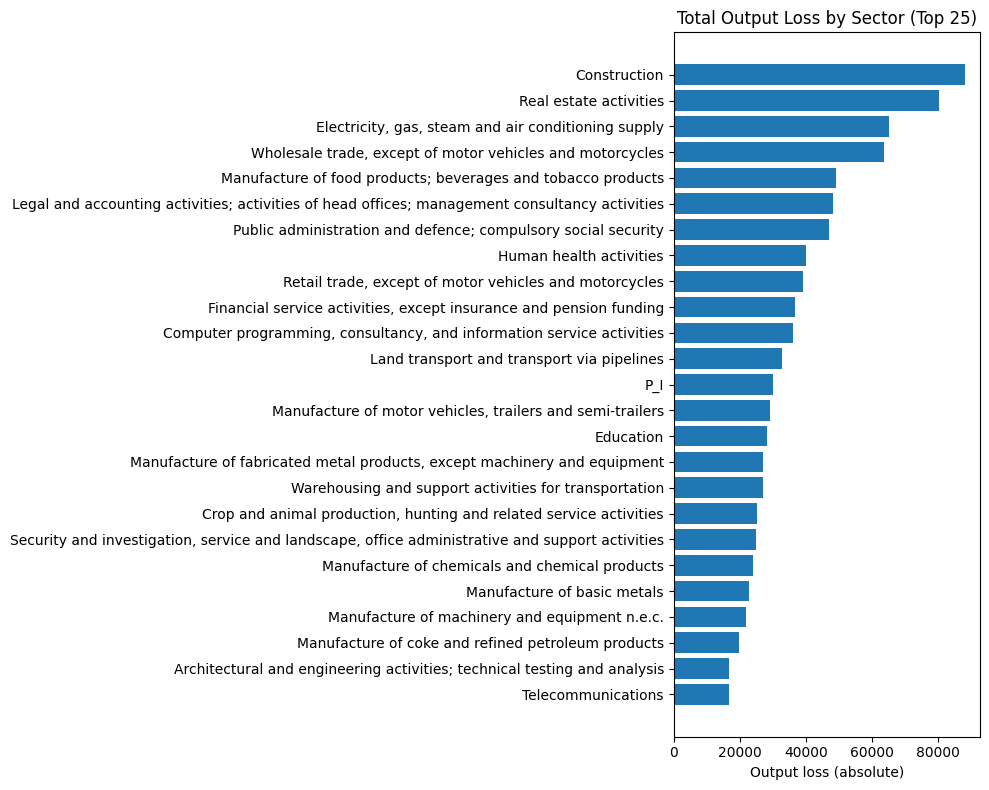

In [14]:
# --- Bar charts (absolute losses) with safe fallback if matplotlib is missing
try:
    import matplotlib.pyplot as plt

    # Country bar
    plt.figure(figsize=(10, 6))
    plt.bar(df_country["country"], df_country["loss_abs"])
    plt.xticks(rotation=90)
    plt.ylabel("Output loss (absolute)")
    plt.title("Total Output Loss by Country")
    plt.tight_layout()
    plt.show()

    # Sector bar (top 25)
    top_sector = df_sector.head(25).sort_values("loss_abs", ascending=True)
    plt.figure(figsize=(10, 8))
    plt.barh(top_sector["sector_name"], top_sector["loss_abs"])
    plt.xlabel("Output loss (absolute)")
    plt.title("Total Output Loss by Sector (Top 25)")
    plt.tight_layout()
    plt.show()

except ModuleNotFoundError:
    print("matplotlib not installed. Showing tables instead.")
    display(df_country.head(20))
    display(df_sector.head(25))


## 6) Diagnostics: demand adjustment loop

The model iterates on post-shock final demand `FD_post` until it matches the feasible implied demand.
Use this section to verify:
- total demand contraction
- how many outer iterations were needed


In [12]:
FD_post_final = results["FD_post_final"]
FD_implied_final = results["FD_implied_final"]

print("Total baseline FD:", float(FD_baseline.sum()))
print("Total final FD_post:", float(FD_post_final.sum()))
print("Total final implied FD:", float(FD_implied_final.sum()))
print("Max unmet FD (nodewise):", float(np.max(FD_post_final - FD_implied_final)))
print("Max slack FD (nodewise):", float(np.max(FD_implied_final - FD_post_final)))

# Optional: inspect the demand history (outer loop)
if "FD_post_history" in results:
    totals = [float(v.sum()) for v in results["FD_post_history"]]
    print("FD_post totals by outer iteration:", totals)


Total baseline FD: 14831340.773248244
Total final FD_post: 14211837.134851892
Total final implied FD: 14211837.203425359
Max unmet FD (nodewise): 0.0
Max slack FD (nodewise): 0.040412221578703625
